In [1]:
%load_ext autoreload
%autoreload 2

import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

import datetime
%matplotlib inline
import time

sys.path.insert(0, '/home/subtle/jon/tools/SimpleElastix/build/SimpleITK-build/Wrapping/Python/Packaging/build/lib.linux-x86_64-3.5/SimpleITK')
import SimpleITK as sitk


import subtle_preprocess as sup
import subtle_io as suio
import subtle_plot as suplot

## load data

In [2]:
path_zero = '/home/subtle/Data/Stanford/lowcon/Patient_0435/8_AX_BRAVO'
path_low = '/home/subtle/Data/Stanford/lowcon/Patient_0435/11_AX_BRAVO_+C_pre_load_10%'
path_full = '/home/subtle/Data/Stanford/lowcon/Patient_0435/14_AX_BRAVO_+C'


In [3]:
ims_zero, hdr_zero = suio.dicom_files(path_zero)
ims_low, hdr_low = suio.dicom_files(path_low)
ims_full, hdr_full = suio.dicom_files(path_full)

print(ims_zero.shape, ims_low.shape, ims_full.shape)

(168, 512, 512) (168, 512, 512) (168, 512, 512)


## grab some images to train

(135, 3, 512, 512)


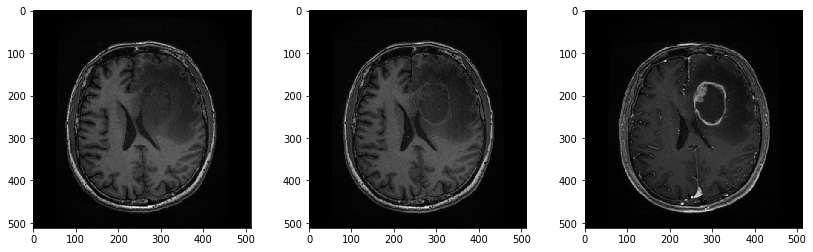

In [9]:
idx_train = np.arange(ims_zero.shape[0])
idx_train = np.arange(int(ims_zero.shape[0]*.1), int(ims_zero.shape[0]*.9))

ims = np.stack((ims_zero[idx_train,:,:], ims_low[idx_train,:,:], ims_full[idx_train,:,:]), axis=1)

print(ims.shape)
ns, nc, nx, ny = ims.shape
# nc number of contrast images, including target (probably 3)
# ns number of examples/slices (probably hundreds)

idx_plot = idx_train[len(idx_train)//2]
plt.figure(figsize=(14,4))
suplot.imshow3(ims[idx_plot,:,:,:], axis=0)

In [10]:
suplot.myshow3d(ims[:,0,:,:].squeeze(), figsize=(5,5))

interactive(children=(IntSlider(value=67, description='z', max=134), Output()), _dom_classes=('widget-interact…

## mask

In [11]:
MASK_VAL = .08
mask = sup.mask_im(ims, threshold=MASK_VAL)

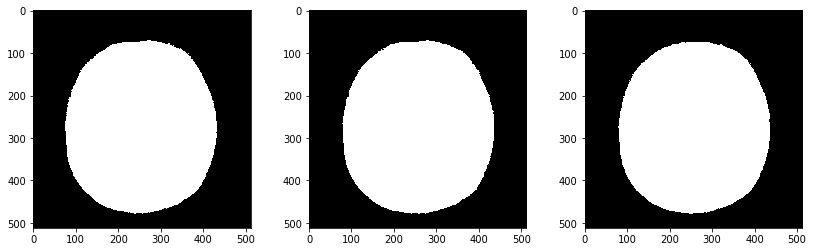

interactive(children=(IntSlider(value=67, description='z', max=134), Output()), _dom_classes=('widget-interact…

In [12]:
plt.figure(figsize=(14,4))
suplot.imshow3(mask[idx_plot,:,:,:])
suplot.myshow3d(mask[:,0,:,:].astype(np.float).squeeze(), figsize=(5,5))

In [13]:
im0 = np.squeeze(ims[:,0,:,:] * mask[:,0,:,:])
im1 = np.squeeze(ims[:,1,:,:] * mask[:,1,:,:])
im2 = np.squeeze(ims[:,2,:,:] * mask[:,2,:,:])

## image scaling

In [14]:
levels=1024
points=50
mean_intensity=True

im1_scaled = sup.scale_im(im0, im1, levels, points, mean_intensity)
im2_scaled = sup.scale_im(im0, im2, levels, points, mean_intensity)



image intensity normalization
scaling done, 3.15 s
image intensity normalization
scaling done, 3.1 s


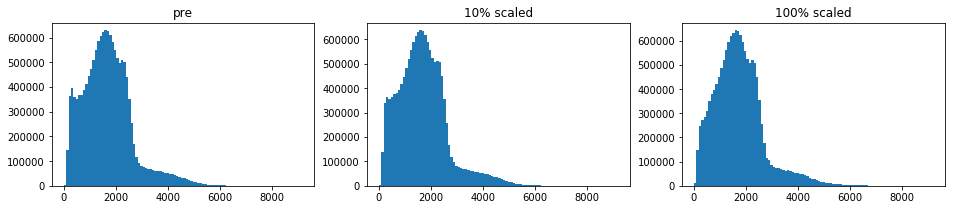

interactive(children=(IntSlider(value=67, description='z', max=134), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=67, description='z', max=134), Output()), _dom_classes=('widget-interact…

In [15]:
plt.figure(figsize=(16,3))
plt.subplot(1,3,1)
plt.hist(im0[im0>0].ravel(), 100)
plt.title('pre')

plt.subplot(1,3,2)
plt.hist(im1_scaled[im1_scaled>0].ravel(), 100);
plt.title('10% scaled')
plt.subplot(1,3,3)
plt.hist(im2_scaled[im2_scaled>0].ravel(), 100);
plt.title('100% scaled')

z = np.concatenate((im0, im1, im2), axis=2)
suplot.myshow3d(z, figsize=(15,5), title='before scaling')

z = np.concatenate((im0, im1_scaled, im2_scaled), axis=2)
suplot.myshow3d(z, figsize=(15,5), title='after scaling')

## image registration

In [16]:
# spars = sitk.GetDefaultParameterMap('translation')
spars = sitk.GetDefaultParameterMap('rigid')

im1_next = im1_scaled.copy()
im1_reg, spars1_reg = sup.register_im(im0, im1_next, param_map=spars, verbose=True)
print('10% transform parameters: {}'.format(spars1_reg[0]['TransformParameters']))

im2_next = im2_scaled.copy()
im2_reg, spars2_reg = sup.register_im(im0, im2_next, param_map=spars, verbose=True)
print('100% transform parameters: {}'.format(spars2_reg[0]['TransformParameters']))

image registration
registration done, 10.9 s
10% transform parameters: ('-0.000168534', '-0.00161121', '0.00954712', '3.82925', '0.769478', '0.327999')
image registration
registration done, 10.4 s
100% transform parameters: ('0.00512391', '-0.00186351', '0.0142911', '4.27404', '0.703196', '-1.34355')


In [17]:
suplot.imshowcmp(im0, im1_next, figsize=(5,5), title='pre vs 10%, before registration')
suplot.imshowcmp(im0, im1_reg, figsize=(5,5), title='pre vs 10%, after registration')
suplot.imshowcmp(im0, im2_next, figsize=(5,5), title='pre vs 100%, before registration')
suplot.imshowcmp(im0, im2_reg, figsize=(5,5), title='pre vs 100%, after registration')

z = np.concatenate((np.abs(im1_reg - im0), np.abs(im2_reg - im0)), axis=2)
suplot.myshow3d(z, figsize=(10,10), title='enhancement diff, |10%-pre| and |100%-pre|')


interactive(children=(IntSlider(value=67, description='z', max=134), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=67, description='z', max=134), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=67, description='z', max=134), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=67, description='z', max=134), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=67, description='z', max=134), Output()), _dom_classes=('widget-interact…